In [ ]:

import re
import unicodedata

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score

from transformers import AutoTokenizer, AutoModel
from pythainlp.tokenize import word_tokenize

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce  

import matplotlib.pyplot as plt
import networkx as nx
import pickle
import warnings


In [136]:
import sys
sys.executable


'c:\\Users\\tt_pe\\Documents\\GitHub\\Project_Thaifakenews\\.venv\\Scripts\\python.exe'

part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp


Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}

In [137]:
# =========================
# Load & clean data
# =========================
df = pd.read_csv('AFNC_news_dataset_tf-2.csv')



In [138]:
# กำหนด mapping dictionary
label_map = {
    'ข่าวจริง': 'true',
    'ข่าวปลอม': 'fake',
}

In [139]:
# ทำความสะอาด label ลบอิโมจิ และแมปค่า 
# Normalization Function

# Remove zero-width characters  
ZW = ''.join(['\u200B', '\u200C', '\u200D', '\uFEFF'])


def normalize_thai(s):
    if pd.isna(s):
        return None
    #non-breaking space
    s = str(s).replace('\u00A0', ' ').translate({ord(ch): None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # collapse repeated diacritics/marks
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['ประเภทข่าว'] = df['ประเภทข่าว'].apply(normalize_thai) #print
df['หมวดหมู่ของข่าว'] = df['หมวดหมู่ของข่าว'].apply(normalize_thai)


In [140]:
# # สร้างคอลัมน์ใหม่ 'label_binary' เป็น binary label จาก mapping
df['label_binary'] = df['ประเภทข่าว'].map(label_map)

# เผื่อ save เป็น CSV ใหม่
#df.to_csv('AFNC_news_dataset_tf.csv', index=False)
#df.to_excel('news_dataset_truefakenews.xlsx', index=False)


# ดูผลลัพธ์
print(df[['หัวข้อข่าว','หมวดหมู่ของข่าว']].head(10))
print(df[['label_binary']].head(10))


                                          หัวข้อข่าว       หมวดหมู่ของข่าว
0  กินหน่อไม้สดปริมาณมาก เสี่ยงรับพิษจากสารไซยาไน...       ผลิตภัณฑ์สุขภาพ
1  กยศ.ช่วยผู้กู้ยืมที่ประสบภัยน้ำท่วมภาคใต้ ขอผ่...  นโยบายรัฐบาล-ข่าวสาร
2  เตือนประชาชนออกจากพื้นที่ชายแดน งดใช้โทรศัพท์ม...  ความสงบและความมั่นคง
3        นายกรัฐมนตรี ทูลเกล้าฯ พระราชกฤษฎีกายุบสภาฯ  นโยบายรัฐบาล-ข่าวสาร
4  ทหารกัมพูชา ยิง BM-21 ลงเขตพื้นที่พลเรือน 55 จ...  ความสงบและความมั่นคง
5  ปตท. ตรึงราคาน้ำมันช่วงปีใหม่ พร้อมมอบโปรโมชัน...  นโยบายรัฐบาล-ข่าวสาร
6  CMAC เตือนประชาชนและผู้ลี้ภัย ระมัดระวังวัตถุร...  ความสงบและความมั่นคง
7  การรถไฟฯ สนับสนุนภารกิจ ส่งตู้คอนเทนเนอร์ตั้งแ...  ความสงบและความมั่นคง
8  อายุครบ 55 ปี ส่งเงินสมทบครบ 180 เดือน รับเงิน...  นโยบายรัฐบาล-ข่าวสาร
9     กองทัพบก จัดกำลังเข้ายึดควบคุมพื้นที่ช่องเสม็ด  ความสงบและความมั่นคง
  label_binary
0         true
1         true
2         true
3         true
4         true
5         true
6         true
7         true
8         true
9         true


In [141]:
# โหลดโมเดลภาษาไทย + จัด device WangchanBERTa
model_WCB = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_WCB, use_fast=False)
#WangchanBERTa
lm_model = AutoModel.from_pretrained(model_WCB)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#ย้ายไปdevice    
lm_model = lm_model.to(device).eval()


Dataset Size: 11111 | ข่าวจริง: 2872, ข่าวปลอม: 8237


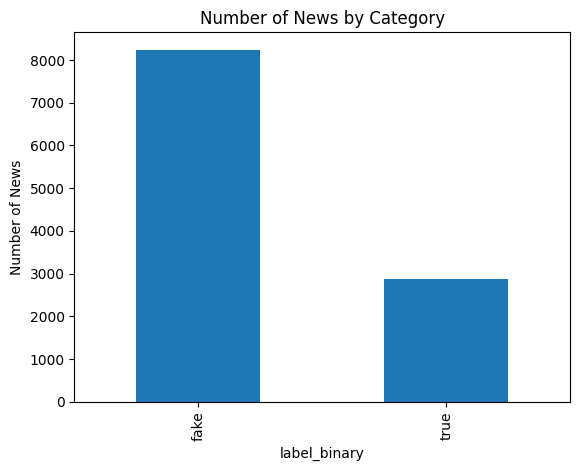

In [142]:
# สรุปข้อมูลเบื้องต้นของจำนวนข่าวในแต่ละคลาส
num_true = (df['label_binary'] == 'true').sum()
num_fake = (df['label_binary'] == 'fake').sum()
print(f"Dataset Size: {len(df)} | ข่าวจริง: {num_true}, ข่าวปลอม: {num_fake}")

# กราฟแท่งแสดงจำนวนข่าวในแต่ละคลาส
try:
    df['label_binary'].value_counts().plot(kind='bar')
    plt.title('Number of News by Category')
    plt.ylabel('Number of News')
    plt.show()
except Exception as e:
    print("Plot skipped:", e)



# ✅ ใช้ raw text ตรง ๆ สำหรับ BERT embedding
#titles = df['title'].tolist()
contents = df['หัวข้อข่าว'].tolist()

In [143]:
# ดูตัวอย่าง content (raw text)
print("\nSample of content:")
print(df[['หัวข้อข่าว']].head(1))

# ถ้าต้องการสถิติ token length จาก BERT tokenizer
encoded_inputs = tokenizer(
    df['หัวข้อข่าว'].tolist(),
    padding=False,
    truncation=False,
    return_tensors=None
)

token_lengths = [len(tokens) for tokens in encoded_inputs['input_ids']]
print("\nToken statistics (from WangchanBERTa tokenizer):")
print(f"Average tokens in หัวข้อข่าว: {sum(token_lengths)/len(token_lengths):.2f}")

#--- TRUE NEWS SAMPLES ---
print("\nSample of true news content:")
print(df[df['label_binary'] == 'true'][['หัวข้อข่าว', 'label_binary']].head(2))

#--- FAKE NEWS SAMPLES ---
print("\nSample of fake news content:")
print(df[df['label_binary'] == 'fake'][['หัวข้อข่าว', 'label_binary']].head(2))



Sample of content:
                                          หัวข้อข่าว
0  กินหน่อไม้สดปริมาณมาก เสี่ยงรับพิษจากสารไซยาไน...

Token statistics (from WangchanBERTa tokenizer):
Average tokens in หัวข้อข่าว: 20.78

Sample of true news content:
                                          หัวข้อข่าว label_binary
0  กินหน่อไม้สดปริมาณมาก เสี่ยงรับพิษจากสารไซยาไน...         true
1  กยศ.ช่วยผู้กู้ยืมที่ประสบภัยน้ำท่วมภาคใต้ ขอผ่...         true

Sample of fake news content:
                                           หัวข้อข่าว label_binary
19   ดื่มนมเยอะ มีผลเสียต่อร่างกาย ทำให้เป็นหลากหล...         fake
20        ต้านโควิด-19 ได้ด้วย มันเทศญี่ปุ่นต้มน้ำขิง         fake


In [144]:
# -------------------------------------------
# ฟังก์ชันสร้าง BERT Embedding WangchanBERT
# -------------------------------------------
#Decorator 
@torch.no_grad()
def get_bert_embeddings_batch(
    texts,
    tokenizer,
    model,
    device,
    max_length=256,
    batch_size=32,
    use_mean_pool=True,
):
    """
    สร้าง BERT embeddings แบบ batch สำหรับลิสต์ของข้อความ (texts)
    คืนค่าเป็น numpy array รูป (N, hidden_size)
    """
    model.eval()  # ให้แน่ใจว่าอยู่ในโหมด eval

    all_embeddings = []

    # loop ทีละ batch
    for start_idx in range(0, len(texts), batch_size):
        batch_texts = texts[start_idx:start_idx + batch_size]

        # กัน NaN / non-string
        batch_texts = [
            "" if (isinstance(t, float) and np.isnan(t)) else str(t)
            for t in batch_texts
        ]

        # Tokenize ทั้ง batch
        inputs = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,          # padding ตาม batch
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state   # (B, seq_len, hidden)

        if use_mean_pool:
            # mean pooling ตาม attention mask
            attn = inputs['attention_mask'].unsqueeze(-1)      # (B, seq_len, 1)
            summed = (last_hidden * attn).sum(dim=1)           # (B, hidden)
            denom = attn.sum(dim=1).clamp(min=1)               # (B, 1)
            emb = (summed / denom).cpu().numpy()               # (B, hidden)
        else:
            # ใช้ CLS token
            emb = last_hidden[:, 0, :].cpu().numpy()           # (B, hidden)

        all_embeddings.append(emb)

    # รวมทุก batch เข้าด้วยกัน
    return np.vstack(all_embeddings)   # (N, hidden_size)


In [145]:
# ====================================================================
# 1. Clean Data & Create Columns (ทำความสะอาดและสร้างคอลัมน์)
# ====================================================================

# กรองแถวที่ไม่มีข้อมูลทิ้งก่อน (สำคัญมาก! เพื่อให้จำนวนแถวเท่ากันทุกขั้นตอน)
df = df.dropna(subset=['หัวข้อข่าว', 'ประเภทข่าว', 'หมวดหมู่ของข่าว']).reset_index(drop=True)

# --- 1.1 จัดการ Label (ประเภทข่าว) ---
classes = sorted(df['ประเภทข่าว'].unique())
label2id = {c: i for i, c in enumerate(classes)}
id2label = {i: c for c, i in label2id.items()}

print(f"Label Classes: {label2id}")

# ✅ สร้างคอลัมน์ 'label_id' ลงใน DataFrame ตามคำขอ
df['label_id'] = df['ประเภทข่าว'].map(label2id)


# --- 1.2 จัดการ Category (หมวดหมู่ของข่าว) ---
cats = sorted(df['หมวดหมู่ของข่าว'].unique())
cat2id = {c: i for i, c in enumerate(cats)}
id2cat = {i: c for c, i in cat2id.items()}

print(f"Category Classes: {cat2id}")

# ✅ สร้างคอลัมน์ 'category_id' ลงใน DataFrame ตามคำขอ
df['category_id'] = df['หมวดหมู่ของข่าว'].map(cat2id)

Label Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}
Category Classes: {'การเงิน-หุ้น': 0, 'ข่าวอื่นๆ': 1, 'ความสงบและความมั่นคง': 2, 'นโยบายรัฐบาล-ข่าวสาร': 3, 'ผลิตภัณฑ์สุขภาพ': 4, 'ภัยพิบัติ': 5, 'ยาเสพติด': 6, 'เศรษฐกิจ': 7}


tensor

In [146]:

# ====================================================================
# 2. สร้าง BERT Embedding จาก content
# ====================================================================

# เตรียมข้อความ
texts = df['หัวข้อข่าว'].fillna("").astype(str).tolist()

print("\nCreating BERT Embeddings for Content (batch)...")
# เรียกฟังก์ชัน embedding (สมมติว่ามีฟังก์ชันนี้อยู่แล้ว)
content_emb = get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device,
    max_length=256,
    batch_size=32,
    use_mean_pool=True,
)

print("content_emb shape:", content_emb.shape)  # เช่น (N, 768)

# Normalize
x_np = normalize(content_emb, axis=1, norm='l2')

# ====================================================================
# 3. กำหนดตัวแปร Target (เรียกใช้จากคอลัมน์ที่สร้างไว้)
# ====================================================================

# ✅ เรียกใช้ได้แล้ว เพราะเราสร้างคอลัมน์ไว้ข้างบนแล้ว
y_np = df['label_id'].values
y_cat_np = df['category_id'].values

print("-" * 30)
print("x_np shape (ก่อน balanced):", x_np.shape)
print("y_np shape (ก่อน balanced):", y_np.shape)
print(f"จำนวนตัวอย่างก่อน balanced (real/fake): {np.unique(y_np, return_counts=True)}")


Creating BERT Embeddings for Content (batch)...
content_emb shape: (11109, 768)
------------------------------
x_np shape (ก่อน balanced): (11109, 768)
y_np shape (ก่อน balanced): (11109,)
จำนวนตัวอย่างก่อน balanced (real/fake): (array([0, 1]), array([2872, 8237]))


หน้าตาเป็นไง ใช้สูตรอะไร ยังไม่ได้กำหนด cate mapping num

เสร็จ embedding 

In [147]:
# ====================================================================
# 1. เตรียมข้อมูลแบบ Balanced (เลือกข่าวล่าสุด แทนการสุ่ม)
# ====================================================================
print("🔄 1. Balancing Data (By Date)...")

# ✅ 1. แก้ไขชื่อคอลัมน์ก่อน (ลบช่องว่างหน้าหลังทิ้งให้หมด)
df.columns = df.columns.str.strip()

# ลองปริ้นท์รายชื่อคอลัมน์ออกมาดู เพื่อความชัวร์
print("📋 รายชื่อคอลัมน์ที่พบ:", df.columns.tolist())

# ⚠️ ตั้งค่าชื่อคอลัมน์วันที่ (ตอนนี้มั่นใจได้ว่าไม่มีวรรคเกิน)
date_col = 'วันและเวลาที่เผยแพร่'  

# ตรวจสอบและแปลงวันที่
if date_col in df.columns:
    # errors='coerce' จะเปลี่ยนค่าที่อ่านไม่ออกเป็น NaT
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)
else:
    print(f"❌ Error: ยังไม่พบคอลัมน์ '{date_col}' อยู่ดี (ลองเช็คชื่อที่ปริ้นท์ด้านบน)")

# แยก Index จริง/ปลอม
idx_real = np.where(y_np == 0)[0]
idx_fake = np.where(y_np == 1)[0]

# หาจำนวนที่น้อยที่สุดเพื่อทำให้เท่ากัน
min_len = min(len(idx_real), len(idx_fake))

# --- 🔥 เริ่มกระบวนการคัดเลือกข่าว (เรียงตามวันที่) ---
if date_col in df.columns:
    # 1. จัดการข่าวปลอม (เรียงใหม่ -> เก่า)
    df_fake_rows = df.iloc[idx_fake]
    df_fake_sorted = df_fake_rows.sort_values(by=date_col, ascending=False)
    
    # ตัดมาเฉพาะส่วนที่ต้องการ (Keep)
    df_fake_kept = df_fake_sorted.head(min_len)
    idx_fake_balanced = df_fake_kept.index.to_numpy()

    # 📌 แสดงตัวอย่างข่าวปลอม
    print("\n" + "="*60)
    print(f"🔎 วิเคราะห์ช่วงเวลาข่าวปลอม ({min_len} ข่าว):")
    print("-" * 60)
    # ใช้ try-except กัน error กรณีวันที่เป็น NaT ทั้งหมด
    try:
        print(f"📅 ใหม่สุด: {df_fake_kept[date_col].max()}")
        print(f"📅 เก่าสุด: {df_fake_kept[date_col].min()}")
    except:
        print("⚠️ ไม่สามารถคำนวณช่วงเวลาได้ (อาจมีค่าว่าง)")

    print("-" * 60)
    print("👇 ตัวอย่างข่าวปลอม 5 อันดับแรก (ใหม่สุด):")
    print(df_fake_kept[[date_col, 'หัวข้อข่าว']].head(5).to_string(index=False))
    
    # --- เพิ่มส่วนแสดง 5 อันดับสุดท้าย ---
    print("\n👇 ตัวอย่างข่าวปลอม 5 อันดับสุดท้าย (เก่าสุดที่เหลืออยู่):")
    print(df_fake_kept[[date_col, 'หัวข้อข่าว']].tail(5).to_string(index=False))


    # 2. จัดการข่าวจริง (เรียงใหม่ -> เก่า)
    df_real_rows = df.iloc[idx_real]
    df_real_sorted = df_real_rows.sort_values(by=date_col, ascending=False)
    
    # ตัดมาเฉพาะส่วนที่ต้องการ (Keep)
    df_real_kept = df_real_sorted.head(min_len)
    idx_real_balanced = df_real_kept.index.to_numpy()

    print("\n" + "="*60)
    print(f"🔎 วิเคราะห์ช่วงเวลาข่าวจริง ({min_len} ข่าว):")
    print("-" * 60)
    print("👇 ตัวอย่างข่าวจริง 5 อันดับแรก (ใหม่สุด):")
    print(df_real_kept[[date_col, 'หัวข้อข่าว']].head(5).to_string(index=False))

    # --- เพิ่มส่วนแสดง 5 อันดับสุดท้าย ---
    print("\n👇 ตัวอย่างข่าวจริง 5 อันดับสุดท้าย (เก่าสุดที่เหลืออยู่):")
    print(df_real_kept[[date_col, 'หัวข้อข่าว']].tail(5).to_string(index=False))
    print("="*60 + "\n")

else:
    # Fallback
    print("⚠️ ใช้วิธีตัดตามลำดับ Index (ไม่พบวันที่)")
    idx_fake_balanced = idx_fake[:min_len]
    idx_real_balanced = idx_real[:min_len]

# รวม Index และสร้าง x, y ใหม่ที่เป็น Balanced ล้วนๆ
idx_balanced = np.concatenate([idx_real_balanced, idx_fake_balanced])
x_balanced = x_np[idx_balanced]
y_balanced = y_np[idx_balanced]

# เก็บ y_cat สำหรับหมวดหมู่ด้วย (ถ้ามี)
if 'y_cat_np' in globals():
    y_cat_balanced = y_cat_np[idx_balanced]

# 🔥 อัปเดต N ให้เป็นจำนวนใหม่
N_balanced = x_balanced.shape[0] 
print(f"✅ Balanced Dataset Size: {N_balanced} samples (Real: {min_len}, Fake: {min_len})")

🔄 1. Balancing Data (By Date)...
📋 รายชื่อคอลัมน์ที่พบ: ['วันและเวลาที่เผยแพร่', 'ลิงค์ข่าว', 'หัวข้อข่าว', 'เนื้อหาข่าว', 'หน่วยงานที่ตรวจสอบ', 'ประเภทข่าว', 'หมวดหมู่ของข่าว', 'จำนวนเข้าชม', 'Hashtag', 'label_binary', 'label_id', 'category_id']


C:\Users\tt_pe\AppData\Local\Temp\ipykernel_24408\1986167056.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)



🔎 วิเคราะห์ช่วงเวลาข่าวปลอม (2872 ข่าว):
------------------------------------------------------------
📅 ใหม่สุด: NaT
📅 เก่าสุด: NaT
------------------------------------------------------------
👇 ตัวอย่างข่าวปลอม 5 อันดับแรก (ใหม่สุด):
วันและเวลาที่เผยแพร่                                                        หัวข้อข่าว
                 NaT                ดื่มนมเยอะ มีผลเสียต่อร่างกาย ทำให้เป็นหลากหลายโรค
                 NaT                       ต้านโควิด-19 ได้ด้วย มันเทศญี่ปุ่นต้มน้ำขิง
                 NaT                   ธ.กรุงไทย ให้ขอสินเชื่อผ่านบัตร ATM ได้ทุกอาชีพ
                 NaT             ติดแอร์ที่ตำแหน่งหัวเตียงนอน จะทำให้เกิดเชื้อราในสมอง
                 NaT  สารระเหยในน้ำมันเบนซิน สามารถดูดพิษจากแมลงกัดต่อย หายใน 3-5 นาที

👇 ตัวอย่างข่าวปลอม 5 อันดับสุดท้าย (เก่าสุดที่เหลืออยู่):
วันและเวลาที่เผยแพร่                                                                                    หัวข้อข่าว
                 NaT                                                

ตัดข้อมูลให้เท่ากัน (Balancing)

สร้างกราฟ (kNN Graph)

แบ่งข้อมูล (Train/Test Split)

สร้าง data object เตรียมเข้าโมเดล

In [148]:
# ====================================================================
# GCN Model Definition 
# ====================================================================
class GCNNet(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256, dropout_rate=0.4):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # ถ้ามี edge weights ให้ใช้
        edge_weight = getattr(data, 'edge_attr', None)
        
        # Layer 1
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 2
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        
        return x  # logits (ส่งไปเข้า CrossEntropyLoss)


# ====================================================================
# Evaluation Function
# ====================================================================
def evaluate_masked(logits, mask, data):
    # เปลี่ยน logits เป็น class prediction (0 หรือ 1)
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    y_true = data.y[mask].cpu().numpy()
    
    # คำนวณ Metrics พื้นฐาน
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # (Optional) ถ้าอยากเห็น Report ละเอียดให้ print ออกมาดูได้
    # print(classification_report(y_true, y_pred, target_names=['News Real', 'News Fake'], digits=4))
    
    return acc, f1m

In [149]:
# ====================================================================
# 2. สร้าง kNN Graph จากข้อมูล Balanced
# ====================================================================
k = 10
print(f"--- 2. Building kNN Graph with k={k} ---")

# 2.1 Fit kNN ด้วย x_balanced
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(x_balanced)
dists, indices = nbrs.kneighbors(x_balanced) 

# 2.2 Create edges
src = np.repeat(np.arange(N_balanced), k-1)
dst = indices[:, 1:].reshape(-1)
w = 1.0 - dists[:, 1:].reshape(-1)

# 2.3 Make undirected
edge_index_np = np.vstack([src, dst])
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

# แปลงเป็น Tensor
edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)

# 2.4 Coalesce
try:
    edge_index, edge_weight = coalesce(edge_index, edge_weight, N_balanced, reduce='mean')
except Exception as e:
    print(f"Warning: coalesce failed ({e})")

# ====================================================================
# 3. แบ่ง Train/Val/Test และสร้าง Data Object
# ====================================================================
print("\n✂️ 3. Splitting Train/Val/Test (on Balanced Data)...")

x_tensor = torch.tensor(x_balanced, dtype=torch.float)
y_tensor = torch.tensor(y_balanced, dtype=torch.long)
idx_all = np.arange(N_balanced)

idx_train, idx_temp = train_test_split(idx_all, test_size=0.30, stratify=y_balanced, random_state=42)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.50, stratify=y_balanced[idx_temp], random_state=42)

train_mask = torch.zeros(N_balanced, dtype=torch.bool); train_mask[idx_train] = True
val_mask   = torch.zeros(N_balanced, dtype=torch.bool); val_mask[idx_val]   = True
test_mask  = torch.zeros(N_balanced, dtype=torch.bool); test_mask[idx_test]  = True

data = Data(x=x_tensor, y=y_tensor, edge_index=edge_index, edge_attr=edge_weight,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask).to(device)

print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")
print(f"Train: {train_mask.sum().item()} | Val: {val_mask.sum().item()} | Test: {test_mask.sum().item()}")

--- 2. Building kNN Graph with k=10 ---

✂️ 3. Splitting Train/Val/Test (on Balanced Data)...
Nodes: 5744, Edges: 83186
Train: 4020 | Val: 862 | Test: 862


In [ ]:
# ====================================================================
# 4. Define Model (GCNNet)
# ====================================================================
class GCNNet(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256, dropout_rate=0.4):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weight = getattr(data, 'edge_attr', None)
        
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x

In [ ]:
import matplotlib.pyplot as plt # อย่าลืม import

# ====================================================================
# 5. Train Model & Plotting (Fixed Version)
# ====================================================================
print("\n🔄 5. Training GCN...")
model_gnn = GCNNet(data.num_features, 2).to(device)
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.001, weight_decay=5e-4)

# 🔥 ข้อมูล Balance แล้ว ไม่ต้องใช้ Class Weights
criterion = nn.CrossEntropyLoss()

# 📊 สร้างตัวแปรเก็บประวัติ
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(1, 201):
    model_gnn.train()
    optimizer.zero_grad()
    out = model_gnn(data)
    
    # ---------------------------------------------------------
    # ❌ แก้ไขจุดที่ 1: เปลี่ยน data.y_label_np เป็น data.y
    # ---------------------------------------------------------
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # --- 🔥 คำนวณ Training Accuracy ---
    with torch.no_grad():
        pred_train = out[data.train_mask].argmax(dim=1)
        
        # -----------------------------------------------------
        # ❌ แก้ไขจุดที่ 2: เปลี่ยน data.label2id เป็น data.y
        # -----------------------------------------------------
        train_correct = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(train_correct) / int(data.train_mask.sum())
        
        # เก็บค่าลง History
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)

    # --- Validation ---
    model_gnn.eval()
    with torch.no_grad():
        pred = model_gnn(data).argmax(dim=1)
        
        # -----------------------------------------------------
        # ❌ แก้ไขจุดที่ 3: เปลี่ยน data.label2id เป็น data.y
        # -----------------------------------------------------
        val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
        val_acc = int(val_correct) / int(data.val_mask.sum())
        
        # เก็บค่า Val Acc ลง History
        history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_gnn.state_dict(), 'best_model.pth')

    if epoch % 20 == 0:
        print(f"   Epoch {epoch:03d}: Loss {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print(f"\n✅ Training Complete! Best Val Acc: {best_val_acc:.4f}")

# ====================================================================
# 📊 Plot Graphs
# ====================================================================
print("📈 Plotting training history...")

# 1. กราฟ Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('graph_loss.png')
plt.show()

# 2. กราฟ Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Training Accuracy', color='blue')
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Accuracy: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('graph_accuracy.png')
plt.show()

print("✅ Saved graphs: graph_loss.png, graph_accuracy.png")


🔄 5. Training GCN...
   Epoch 020: Loss 0.4924 | Val Acc: 0.7889
   Epoch 040: Loss 0.4051 | Val Acc: 0.8016
   Epoch 060: Loss 0.3671 | Val Acc: 0.8144
   Epoch 080: Loss 0.3476 | Val Acc: 0.8179
   Epoch 100: Loss 0.3371 | Val Acc: 0.8225
   Epoch 120: Loss 0.3290 | Val Acc: 0.8248
   Epoch 140: Loss 0.3237 | Val Acc: 0.8318
   Epoch 160: Loss 0.3201 | Val Acc: 0.8364
   Epoch 180: Loss 0.3157 | Val Acc: 0.8376
   Epoch 200: Loss 0.3132 | Val Acc: 0.8387

✅ Training Complete! Best Val Acc: 0.8399


In [151]:
# ====================================================================
# 6. Save Artifacts (ใช้ข้อมูล x_balanced ที่เตรียมไว้ตอนแรก)
# ====================================================================
artifacts = {
    'x_np': x_balanced,         # ✅ ใช้ข้อมูลเรียงวันที่
    'y_cat_np': y_cat_balanced if 'y_cat_balanced' in globals() else None, 
    'y_label_np': y_balanced,
    'id2cat': id2cat if 'id2cat' in globals() else None,
    'id2label': {0: 'ข่าวจริง', 1: 'ข่าวปลอม'},
    'k': 10
}
with open('artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)
print("✅ Saved 'best_model.pth' and 'artifacts.pkl' (Date-Balanced Version)")

✅ Saved 'best_model.pth' and 'artifacts.pkl' (Date-Balanced Version)


In [152]:
def predict_news(
    content,
    topn=10,
    x_np=None,
    label2id=None,
    id2label=None,
    y_cat_np=None,
    id2cat=None,
    device=None,
    nbrs=None,
    model_gnn=None,
    embed_fn=None
):  
    # 0) Validate basics
    if embed_fn is None:
         raise ValueError("Missing 'embed_fn'. Please provide the embedding function.")
    
    # 1) Embedding: แปลงข้อความใหม่เป็น Vector
    # embed_fn ต้องคืนค่าเป็น list ของ numpy array หรือ tensor
    emb_batch = embed_fn([content])
    content_emb = emb_batch[0]
    
    # Normalize (L2) เพื่อให้เหมือนตอนเทรน และเหมาะกับ Cosine Similarity
    emb = normalize(content_emb.reshape(1, -1), axis=1, norm='l2')[0]

    # 2) KNN Search: หาข่าวเก่าที่คล้ายกัน
    # nbrs ต้องเป็นโมเดลที่ fit กับ x_np (Balanced) มาแล้ว
    dists, idxs = nbrs.kneighbors(emb.reshape(1, -1), n_neighbors=topn)
    idxs = idxs[0]
    
    # --- ส่วนทำนาย Category (Majority Vote) ---
    pred_category = "ไม่ระบุ"
    neighbor_cats = []
    
    if y_cat_np is not None and id2cat is not None:
        try:
            neighbor_cat_ids = y_cat_np[idxs]
            neighbor_cats = [id2cat[cid] for cid in neighbor_cat_ids]
            
            # โหวตหาหมวดหมู่ที่เจอบ่อยที่สุดในหมู่เพื่อนบ้าน
            most_common = Counter(neighbor_cats).most_common(1)
            if most_common:
                pred_category = most_common[0][0]
        except Exception as e:
            print(f"⚠️ Warning in Category Prediction: {e}")
            pass
    # ----------------------------------------

    # 3) Build Graph for GCN
    # สร้างกราฟดาว (Star Graph): ข่าวใหม่ (center=0) เชื่อมกับข่าวเก่า (neighbors=1..k)
    # ข้อมูล Node Feature: [ข่าวใหม่, เพื่อน1, เพื่อน2, ..., เพื่อนk]
    X_new = np.vstack([emb, x_np[idxs]])
    
    center = 0
    neighbors = np.arange(1, topn + 1)
    
    # สร้างเส้นเชื่อม (ไป-กลับ)
    # เส้นขาไป: 0 -> 1, 0 -> 2, ...
    # เส้นขากลับ: 1 -> 0, 2 -> 0, ...
    edge_index_new = np.concatenate([
        np.stack([np.full(topn, center), neighbors]),
        np.stack([neighbors, np.full(topn, center)])
    ], axis=1)
    
    # สร้างน้ำหนักเส้นเชื่อม (Weight) จากค่า Distance
    # ยิ่งใกล้ยิ่งค่ามาก (1 - dist)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    # สร้าง Data Object สำหรับ PyTorch Geometric
    # ⚠️ ใช้ edge_attr เพื่อให้ตรงกับโครงสร้างโมเดลที่เทรนมา
    data_new = Data(
        x=torch.tensor(X_new, dtype=torch.float, device=device),
        edge_index=torch.tensor(edge_index_new, dtype=torch.long, device=device),
        edge_attr=torch.tensor(edge_weight_new, dtype=torch.float, device=device), 
    )

    # 4) Predict Real/Fake
    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        
        # เอาผลลัพธ์ของ Node ที่ 0 (ข่าวใหม่)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        
        pred_id = int(np.argmax(probas)) 
        label_pred = id2label[pred_id]

    return {
        'label': label_pred,           # ผลทำนาย: ข่าวจริง/ปลอม
        'probability': float(probas[pred_id]), # ความมั่นใจ (0.0 - 1.0)
        'proba_all': probas.tolist(),  # ค่าความน่าจะเป็นของทั้ง 2 คลาส
        'category': pred_category,     # ผลทำนาย: หมวดหมู่
        'neighbor_cats': neighbor_cats, # หมวดหมู่ของข่าวที่คล้ายกัน
        'pred_id': pred_id               # ตัวเลขคลาสที่ทำนาย
    }

In [153]:
# ====================================================================
# PART 1 — Evaluate GCN on Test set
# ====================================================================

model_gnn.eval()
with torch.no_grad():
    # ทำนายข้อมูลทั้งหมด (แต่เราจะเลือกดูแค่ Test Mask)
    final_out_gcn = model_gnn(data)

    # ดึงเฉพาะส่วนที่เป็น Test set
    y_true_gcn = data.y[data.test_mask].cpu().numpy()
    y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()

# -----------------------------
# Metrics (รวม)
# -----------------------------
acc = accuracy_score(y_true_gcn, y_pred_gcn)
precision = precision_score(y_true_gcn, y_pred_gcn, average='weighted', zero_division=0)
recall = recall_score(y_true_gcn, y_pred_gcn, average='weighted', zero_division=0)
f1 = f1_score(y_true_gcn, y_pred_gcn, average='weighted', zero_division=0)

# -----------------------------
# สร้าง results_gcn (เก็บไว้ใช้ตอนจบ)
# -----------------------------
results_gcn = {
    "Accuracy": float(acc),
    "Precision_weighted": float(precision),
    "Recall_weighted": float(recall),
    "F1_weighted": float(f1),
}

# -----------------------------
# พิมพ์ผลลัพธ์
# -----------------------------
print("-" * 60)
print("GCN Test Evaluation (from Test Mask)")
print("-" * 60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("-" * 60)

# 📌 ส่วนที่เพิ่ม: ดูรายละเอียดแยกคลาส (สำคัญมากสำหรับข้อมูล Imbalanced)
print("\nDetailed Classification Report:")
# target_names ต้องเรียงตาม id 0, 1 ของคุณ (เช่น ['Real', 'Fake'])
print(classification_report(y_true_gcn, y_pred_gcn, digits=4))

print("-" * 60)

------------------------------------------------------------
GCN Test Evaluation (from Test Mask)
------------------------------------------------------------
Accuracy:  0.8353
Precision: 0.8363
Recall:    0.8353
F1-score:  0.8351
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.8550    0.8074    0.8305       431
           1     0.8176    0.8631    0.8397       431

    accuracy                         0.8353       862
   macro avg     0.8363    0.8353    0.8351       862
weighted avg     0.8363    0.8353    0.8351       862

------------------------------------------------------------


In [154]:
# 📌  สร้างชุดข้อมูลทดสอบใหม่ (Test Set) 20 ข่าว
# 'label_true': 0 = ข่าวจริง, 1 = ข่าวปลอม (ตาม label2id: {'ข่าวจริง': 0, 'ข่าวปลอม': 1})
test_news_data = [
    # --- ข่าวจริง 10 ตัวอย่าง (Label 0) ---
    {"content": "ททท. เปิดตัว “ลิซ่า” เป็นตัวแทนการท่องเที่ยวไทย Amazing Thailand Ambassador","label_true": 0},
    {"content": "สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล' หลังพังถล่มจากฝนตกหนัก", "label_true": 0},
    {"content": "บขส. เปิดให้บริการเดินรถโดยสาร เส้นทาง ขอนแก่น – นครหลวงเวียงจันทน์", "label_true": 0},
    {"content": "อุทยานฯ เขาพนมเบญจา ชวนนักท่องเที่ยว ตามรอยจูราสสิค เวิลด์ กำเนิดชีวิตใหม่ น้ำตกห้วยโต้", "label_true": 0},
    {"content": "พบอิฐโบราณชิ้นสำคัญ หลักฐานทางประวัติศาสตร์ที่เก่าแก่ของเชียงราย", "label_true": 0},
    {"content": "ปิดเทอม สวนสัตว์เปิดเขาเขียว เผยโฉม 'ลูกสมเสร็จตัวล่าสุด' เด็กเที่ยวฟรี 23 ตุลาคมนี้", "label_true": 0},
    {"content": "อาการเจ็บหน้าอก สัญญาณอันตรายที่ไม่ควรมองข้าม","label_true": 0},
    {"content": "กกล.บูรพา จับกุมแรงงานกัมพูชา 11 คน ลักลอบข้ามชายแดนสระแก้ว","label_true": 0},
    {"content": "ททท.คาด 'เทศกาลกินผักภูเก็ต 2568' คึกคัก รายได้ทะลุ 22,000 ล้านบาท หนุนเศรษฐกิจสะพัด", "label_true": 0},
    {"content": "“ข้าวต้ม” ฟื้นตัวดี ถีบตัวลุกได้ ทีมแพทย์ช่วยกายภาพต่อเนื่อง", "label_true": 0},
    
    # --- ข่าวปลอม 10 ตัวอย่าง (Label 1) ---
    {"content": "ด่วน! สะพานกรุงเทพถล่ม มีผู้เสียชีวิต 36 ราย", "label_true": 1},
    {"content": "กระทรวงยุติธรรม ร่วมกับ ตำรวจไซเบอร์ เปิดให้ลงทะเบียนยื่นหลักฐาน เพื่อรับเงินคืนจากมิจฉาชีพ", "label_true": 1},
    {"content": "การดื่มน้ำมะนาวสามารถทำลายมะเร็งเนื้อร้ายที่รุนแรงได้", "label_true": 1},
    {"content": "ผู้สูงอายุ 60 ปีขึ้นไป รับเงินอุดหนุนพิเศษ 3,000 บาท ไม่ต้องลงทะเบียน", "label_true": 1},
    {"content": "กรมการขนส่งเปิดทำใบขับขี่ออนไลน์ ผ่านเพจเฟซบุ๊ก Pages DTL Noline", "label_true": 1},
    {"content": "กินถั่วลิสงวันละ 1 กำมือ ช่วยรักษาอาการวัยทอง อารมณ์แปรปรวน","label_true": 1},
    {"content": "กฟภ. เปิดช่องทางติดต่อด่วน ทางไลน์ไอดี 'pea9394'", "label_true": 1},
    {"content": "สินเชื่อด่วนออมสิน สมัครง่าย ไม่ต้องใช้เอกสาร ติดต่อได้ที่เพจ Ulises Elizabeth Love", "label_true": 1},
    {"content": "รองแม่ทัพภาคที่ 2 ถูกตำหนิ เหตุรับเงินบริจาควัด", "label_true": 1},
    {"content": "วางก้อนน้ำแข็งบนท้ายทอย ช่วยรักษาโรคทางเดินหายใจ โรคหลอดเลือดหัวใจ และอาการปวดเมื่อยตามร่างกาย", "label_true": 1}
]

In [155]:
# ✅ ปิดคำเตือน FutureWarning ที่น่ารำคาญจาก Transformers (ปิดแบบเข้มงวด)
# ดักจับข้อความที่มีคำว่า encoder_attention_mask แบบครอบคลุม
warnings.filterwarnings("ignore", message=".*encoder_attention_mask.*")
# ดักจับเฉพาะเจาะจงสำหรับ CamembertSdpaSelfAttention ที่โผล่มาบ่อยๆ
warnings.filterwarnings("ignore", message=".*CamembertSdpaSelfAttention.*")

# ====================================================================
# PART 2 — Predict multiple new news samples (With Category)
# ====================================================================

#  Fit KNN ใหม่ด้วยข้อมูลชุดที่เลือกมา
print(f"🔄 Re-fitting KNN with data size: {len(x_balanced)}...")
current_nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(x_balanced)

# สร้าง id2label จาก label2id ที่มีอยู่
id2label = {i: c for c, i in label2id.items()}

# เก็บค่าจริงและค่าทำนาย (สำหรับ Real/Fake)
y_true = []
y_pred = []

print("-" * 80)
print(f"--- Running Prediction on {len(test_news_data)} News Samples ---")
print("-" * 80)

# สร้างฟังก์ชันฝังตัวแปร (Wrapper)
my_embed_fn = lambda texts: get_bert_embeddings_batch(
    texts,
    tokenizer=tokenizer,
    model=lm_model,
    device=device
)

for i, news in enumerate(test_news_data):
    try:
        # เรียกใช้ฟังก์ชัน
        result = predict_news(
            content=news['content'],
            x_np=x_balanced,       # ✅ ใช้ข้อมูลที่เลือกมา (Auto-select)
            nbrs=current_nbrs,    # ✅ ใช้ KNN ตัวใหม่
            label2id=label2id,
            id2label=id2label,
            y_cat_np=y_cat_balanced if 'y_cat_balanced' in globals() else y_cat_np, 
            id2cat=id2cat,      
            device=device,
            topn=k,
            model_gnn=model_gnn,
            embed_fn=my_embed_fn
        )

        # -----------------------------------------------------------
        # ดึง ID มาใช้ได้เลย
        # -----------------------------------------------------------
        pred_id = result['pred_id']

        y_true.append(news["label_true"])
        y_pred.append(pred_id)

        # เช็คความถูกต้อง (เฉพาะ Real/Fake)
        status = "✅" if pred_id == news["label_true"] else "❌"
        
        # 📌📌 ส่วนที่เพิ่ม: แสดงผลละเอียดเพื่อ Debug 📌📌
        print(f"[{status}] News: {news['content'][:50]}...") # ตัดข้อความสั้นๆ
        print(f"    TRUE: {id2label[news['label_true']]} | PRED: {result['label']} | Prob: {result['probability']:.3f}")
        print(f"    -> หมวดหมู่ข่าวนี้: {result['category']}")
        print(f"    -> เพื่อนบ้านที่เจอ ({k} คน): {result['neighbor_cats']}") 
        print("-" * 50)
    
    except Exception as e:
        print(f"Error predicting sample {i}: {e}")

# =====================================================================
# CONFUSION MATRIX & METRICS (เฉพาะ Real/Fake)
# =====================================================================
if len(y_pred) > 0:
    print("\n" + "="*60)
    print(" SUMMARY REPORT ")
    print("="*60)
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # ถ้าอยากปริ้นท์สวยๆ
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print(f"True Neg (0): {tn} | False Pos (0->1): {fp}")
        print(f"False Neg (1->0): {fn} | True Pos (1): {tp}")

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print("-" * 30)
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("-" * 30)

    print("\nClassification Report:")
    # ตรวจสอบว่า Class 0 คืออะไร Class 1 คืออะไร ให้ชัวร์
    print(classification_report(
        y_true,
        y_pred,
        target_names=[id2label[0], id2label[1]], 
        zero_division=0
    ))

🔄 Re-fitting KNN with data size: 5744...
--------------------------------------------------------------------------------
--- Running Prediction on 20 News Samples ---
--------------------------------------------------------------------------------
[✅] News: ททท. เปิดตัว “ลิซ่า” เป็นตัวแทนการท่องเที่ยวไทย Am...
    TRUE: ข่าวจริง | PRED: ข่าวจริง | Prob: 0.625
    -> หมวดหมู่ข่าวนี้: นโยบายรัฐบาล-ข่าวสาร
    -> เพื่อนบ้านที่เจอ (10 คน): ['นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'การเงิน-หุ้น', 'การเงิน-หุ้น', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร', 'นโยบายรัฐบาล-ข่าวสาร']
--------------------------------------------------
[✅] News: สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล'...
    TRUE: ข่าวจริง | PRED: ข่าวจริง | Prob: 0.998
    -> หมวดหมู่ข่าวนี้: ภัยพิบัติ
    -> เพื่อนบ้านที่เจอ (10 คน): ['ภัยพิบัติ', 'ภัยพิบัติ', 'ภัยพิบัติ', 'นโยบายรัฐบาล-ข่าวสาร', 'ภัยพิบัติ', 'ภัยพิบัติ', 'นโยบายรัฐบา

In [156]:
# # ====================================================================
# # PART 3 — Interactive Prediction (Loop)
# # ====================================================================

# # --------------------------------------------------------------------
# # 2. 🔄 Re-fit KNN (สำคัญมาก! ต้องทำใหม่ให้ตรงกับข้อมูล)
# # --------------------------------------------------------------------
# print(f"🔄 กำลังจูน KNN ใหม่ด้วยข้อมูลจำนวน {len(x_balanced)} ตัวอย่าง...")
# current_nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(x_balanced)


# # 3. Wrapper Function
# my_embed_fn = lambda texts: get_bert_embeddings_batch(
#     texts,
#     tokenizer=tokenizer,
#     model=lm_model,
#     device=device
# )

# print("\n" + "="*60)
# print("🤖 ระบบทดสอบข่าวปลอม AI (พิมพ์ 'exit' หรือ 'q' เพื่อออก)")
# print("="*60)

# while True:
#     print("\n" + "-"*60)
#     content = input("✍️ กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน): \n>> ").strip()

#     # เช็คเงื่อนไขออกจาก Loop
#     if content.lower() in ['exit', 'q', 'quit', 'ออก']:
#         print("👋 จบการทำงาน")
#         break

#     if not content:
#         continue

#     try:
#         # เรียกใช้ฟังก์ชันทำนาย (ส่งตัวแปร current_... ที่เราเตรียมไว้)
#         result = predict_news(
#             content=content,
#             x_np=x_balanced,       # ✅ ใช้ข้อมูล Balanced
#             nbrs=current_nbrs,    # ✅ ใช้ KNN ที่ Fit ใหม่แล้ว
#             label2id=label2id,
#             id2label=id2label,
#             y_cat_np=y_cat_balanced, # ✅ ข้อมูลหมวดหมู่
#             id2cat=id2cat,
#             device=device,
#             topn=k,
#             model_gnn=model_gnn,
#             embed_fn=my_embed_fn
#         )

#         # แสดงผลลัพธ์สวยงาม
#         print("\n" + "═"*50)
#         print("📰 ผลการวิเคราะห์ (Analysis Result)")
#         print("═"*50)
        
#         status_icon = "✅" if result['label'] == 'ข่าวจริง' else "🚨"
        
#         print(f"{status_icon} สถานะข่าว :  {result['label']}")
#         print(f"📊 ความมั่นใจ :  {result['probability']*100:.2f}%")
#         print(f"📂 หมวดหมู่   :  {result['category']}")
#         print("-" * 50)
#         print(f"🔎 เพื่อนบ้าน {k} ข่าวที่คล้ายกัน (หมวดหมู่):")
#         print(f"   {result['neighbor_cats']}")
#         print("═"*50)

#     except Exception as e:
#         print(f"❌ ERROR: {e}")
#         traceback.print_exc()

In [161]:
# ==========================================
# 🕵️‍♂️ โค้ดทดสอบโมเดลใน Notebook (Sanity Check)
# ==========================================
model_gnn.eval() # เข้าโหมดทดสอบ

# 1. หาข่าวจริงมาสักอัน (เอาจาก y_balanced ที่เป็น 0)
idx_test_real = np.where(y_balanced == 0)[0][0] # หยิบข่าวจริงตัวแรกมา
idx_test_fake = np.where(y_balanced == 1)[0][0] # หยิบข่าวปลอมตัวแรกมา

# 2. ลองทำนาย
with torch.no_grad():
    out = model_gnn(data)
    pred = out.argmax(dim=1).cpu().numpy()
    probs = torch.softmax(out, dim=1).cpu().numpy()

# 3. ดูผลลัพธ์
print(f"--- 🟢 ทดสอบข่าวจริง (Index {idx_test_real}) ---")
print(f"เฉลย: {y_balanced[idx_test_real]} (0=จริง)")
print(f"โมเดลทาย: {pred[idx_test_real]}")
print(f"ความมั่นใจ: {probs[idx_test_real]}")

print(f"\n--- 🔴 ทดสอบข่าวปลอม (Index {idx_test_fake}) ---")
print(f"เฉลย: {y_balanced[idx_test_fake]} (1=ปลอม)")
print(f"โมเดลทาย: {pred[idx_test_fake]}")
print(f"ความมั่นใจ: {probs[idx_test_fake]}")

--- 🟢 ทดสอบข่าวจริง (Index 0) ---
เฉลย: 0 (0=จริง)
โมเดลทาย: 0
ความมั่นใจ: [0.93606734 0.06393259]

--- 🔴 ทดสอบข่าวปลอม (Index 2872) ---
เฉลย: 1 (1=ปลอม)
โมเดลทาย: 1
ความมั่นใจ: [0.19306532 0.80693465]


savemodel

In [158]:
#--- ตัวอย่างการสร้าง GCN โมเดลง่ายๆ ---
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


graph

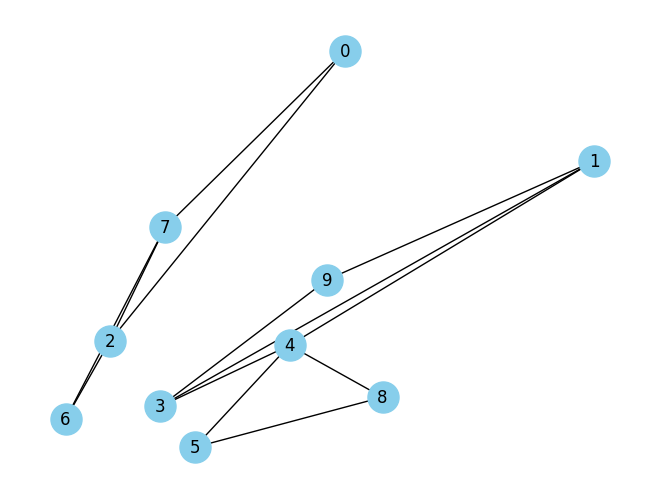

In [159]:
#--- ตัวอย่างการสร้างกราฟ kNN ง่ายๆ ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (สมมติแทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# วาดกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


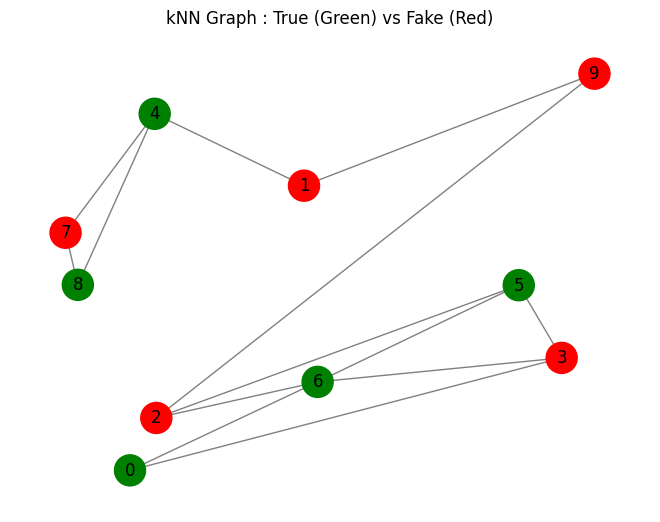

In [160]:
#--- ตัวอย่างการสร้างกราฟ kNN พร้อมสีโหนดจาก label ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (แทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# label ของโหนด (0=ข่าวปลอม, 1=ข่าวจริง)
y = np.random.randint(0, 2, size=10)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# สร้างกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label → สี
color_map = ["red" if label == 0 else "green" for label in y]

# วาดกราฟ
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()
